# Install and Load Libraries/Data

In [88]:
#!pip install /kaggle/input/skorch-whl-files/Skorch_WHL_Files/skorch-1.0.0-py3-none-any.whl
#!pip install skorch
#!pip install optuna

In [89]:
import os
import random
from concurrent.futures import ThreadPoolExecutor
from glob import glob
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, auc, classification_report, 
                             cohen_kappa_score, confusion_matrix, make_scorer, 
                             roc_curve, auc, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, 
                                     train_test_split, cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, OneHotEncoder, 
                                    OrdinalEncoder, StandardScaler, label_binarize)
from sklearn.utils.class_weight import compute_class_weight
from skorch import NeuralNetClassifier
from torch import nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import optuna

# Set the seed for reproducibility
def set_seed(seed=22):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(22)

os.environ["PYTHONWARNINGS"] = "ignore"

In [90]:
# Define file paths
train_csv_path = './data/train.csv'
test_csv_path = './data/test.csv'
series_train_path = './data/series_train.parquet'
series_test_path = './data/series_test.parquet'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
train_df = train_df[train_df['sii'].notna()].copy()

# Feature Engineering

In [91]:
def feature_engineering(df):
    """
    Perform feature engineering by creating new features based on existing ones.
    """
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']
    df['SDS_InternetHours'] = df['SDS-SDS_Total_T'] * df['PreInt_EduHx-computerinternet_hoursday']
    
    return df

In [92]:
# Apply feature engineering
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

# Adding Parquet Data

In [93]:
def process_file(filename, dirname, window_duration=60 * 60):
    """
    Processes a single Parquet file to compute:
    - Global summary statistics for selected features
    - Window-level statistics with z-scores for the interaction term ('light' * 'enmo'),
      separated by weekday/weekend.
    """
    # Load data
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    
    # Drop 'step' column if present
    if 'step' in df.columns:
        df.drop('step', axis=1, inplace=True)
    
    # Initialize stats dictionary
    stats = {}
    
    # Compute non-wear statistics
    non_wear_sum = df['non-wear_flag'].sum()
    non_wear_count = len(df['non-wear_flag'])
    stats['non_wear_sum'] = non_wear_sum
    stats['non_wear_proportion'] = non_wear_sum / non_wear_count if non_wear_count > 0 else 0
    
    # Filter out rows where non-wear_flag is active
    df = df[df['non-wear_flag'] == 0].copy()
    
    # Compute statistics for 'quarter'
    stats['quarter_min'] = df['quarter'].min()
    stats['quarter_max'] = df['quarter'].max()
    
    # Compute global statistics for 'enmo', 'anglez', 'light', and 'battery_voltage'
    for feature in ['enmo', 'anglez', 'light', 'battery_voltage']:
        stats[f'{feature}_mean'] = df[feature].mean()
        stats[f'{feature}_std'] = df[feature].std()
        stats[f'{feature}_min'] = df[feature].min()
        stats[f'{feature}_max'] = df[feature].max()

    stats['relative_date_PCIAT_max'] = df['relative_date_PCIAT'].max()
    
    # Create interaction term
    df['interaction'] = df['light'] * df['enmo']
    
    # Compute global mean and std for the interaction term
    interaction_global_mean = df['interaction'].mean()
    interaction_global_std = df['interaction'].std()
    
    # Split data by weekdays and weekends
    df_weekdays = df[df['weekday'] <= 5]
    df_weekends = df[df['weekday'] >= 6]
    
    # Function to compute window-level stats
    def compute_window_stats(data, feature, global_mean, global_std):
        data['window'] = (data['time_of_day'] % 86400 // window_duration).astype(int)
        window_stats = data.groupby('window').agg(
            feature_mean=(feature, 'mean'),
            feature_std=(feature, 'std')
        ).reset_index()
        if global_std > 0:  # Avoid division by zero
            window_stats[f'{feature}_z_score'] = (window_stats['feature_mean'] - global_mean) / global_std
        else:
            window_stats[f'{feature}_z_score'] = 0
        return window_stats.drop(columns=['feature_mean'])
    
    # Compute window stats for the interaction term separately for weekdays and weekends
    interaction_weekday_stats = compute_window_stats(df_weekdays.copy(), 'interaction', interaction_global_mean, interaction_global_std)
    interaction_weekend_stats = compute_window_stats(df_weekends.copy(), 'interaction', interaction_global_mean, interaction_global_std)
    
    # Combine window stats
    window_stats = pd.concat([
        interaction_weekday_stats.assign(time_frame='weekday', feature='interaction'),
        interaction_weekend_stats.assign(time_frame='weekend', feature='interaction')
    ], ignore_index=True)
    
    # Return combined statistics
    return {
        'summary_stats': stats,
        'window_stats': window_stats,
        'id': filename.split('=')[1]
    }


def load_time_series(dirname, window_duration=60 * 60):
    """
    Loads all time-series files and computes modified summary statistics for each.
    """
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname, window_duration), ids), total=len(ids)))
    
    # Separate global stats, IDs, and window-level details
    global_stats_list = [result['summary_stats'] for result in results]
    ids_list = [result['id'] for result in results]
    window_stats_list = [result['window_stats'] for result in results]
    
    # Create DataFrame for global stats
    global_stats_df = pd.DataFrame(global_stats_list)
    global_stats_df['id'] = ids_list

    # Concatenate all window stats into a single DataFrame
    window_stats_df = pd.concat(
        [df.assign(id=id_val) for df, id_val in zip(window_stats_list, ids_list)], ignore_index=True
    )
    
    return global_stats_df, window_stats_df


In [94]:
# Load train and test statistics
train_global_stats, train_window_stats = load_time_series(series_train_path)
test_global_stats, test_window_stats = load_time_series(series_test_path)

# Merge global stats into processed train and test DataFrames
combined_train = pd.merge(train_df, train_global_stats, on='id', how='left')
combined_test = pd.merge(test_df, test_global_stats, on='id', how='left')

100%|██████████| 2/2 [00:00<00:00, 21.90it/s]


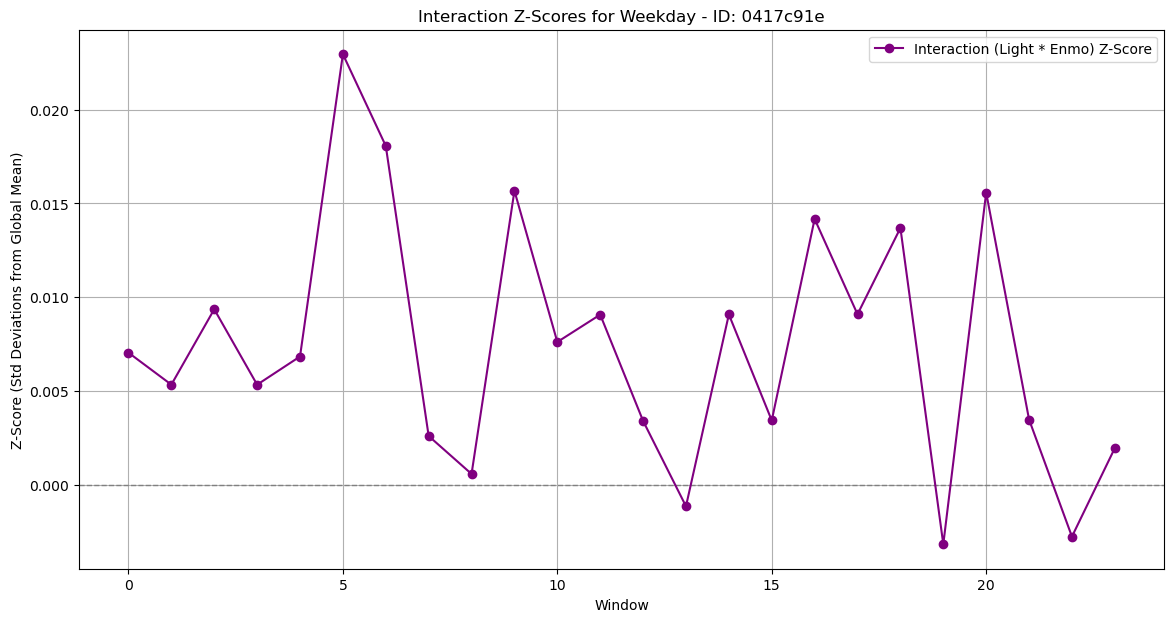

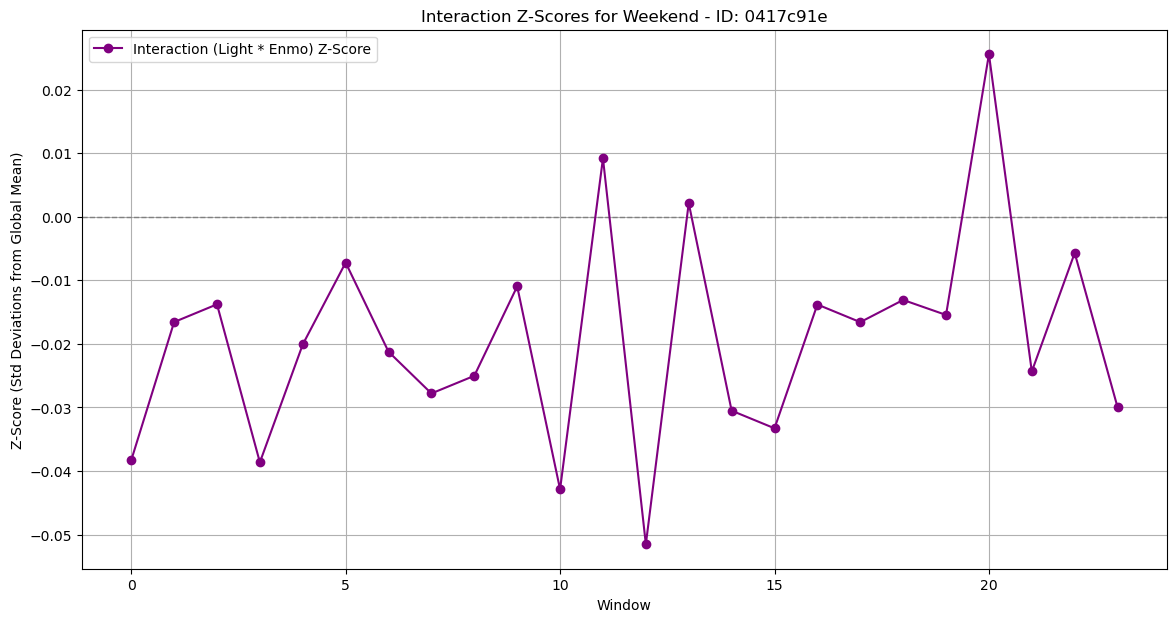

In [95]:
def plot_interaction_z_scores(window_stats_df, specified_id):
    """
    Plots the z-scores of the interaction term (`light * enmo`) for weekdays and weekends for a specified ID.

    Parameters:
    - window_stats_df (DataFrame): DataFrame containing window-level statistics.
    - specified_id (str): The ID for which to plot the z-scores.
    """
    # Filter data for the specified ID
    df_id = window_stats_df[window_stats_df['id'] == specified_id]
    
    if df_id.empty:
        print(f"No data found for ID: {specified_id}")
        return
    
    # Plot z-scores for each time frame (weekday/weekend)
    for time_frame in ['weekday', 'weekend']:
        df_time = df_id[df_id['time_frame'] == time_frame]
        
        plt.figure(figsize=(14, 7))
        plt.title(f"Interaction Z-Scores for {time_frame.capitalize()} - ID: {specified_id}")
        plt.xlabel("Window")
        plt.ylabel("Z-Score (Std Deviations from Global Mean)")
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Reference line

        # Plot interaction z-scores
        df_feature = df_time[df_time['feature'] == 'interaction']
        plt.plot(
            df_feature['window'],
            df_feature['interaction_z_score'],
            label='Interaction (Light * Enmo) Z-Score',
            marker='o',
            color='purple'
        )

        plt.legend()
        plt.grid()
        plt.show()

# Example usage
plot_interaction_z_scores(train_window_stats, '0417c91e')

In [96]:
# Pivot window stats for train and test
def pivot_window_stats(window_stats_df):
    """
    Pivots window stats to have columns like 'metric_timeframe_feature_window#'.
    """
    # Create a unique column name combining metric, time_frame, feature, and window
    window_stats_pivot = window_stats_df.melt(
        id_vars=['id', 'window', 'time_frame', 'feature'],
        var_name='metric',
        value_name='value'
    )
    # Combine metric, time_frame, feature, and window into one column name
    window_stats_pivot['metric_window'] = (
        window_stats_pivot['metric'] + '_' +
        window_stats_pivot['time_frame'] + '_' +
        window_stats_pivot['feature'] + '_window' +
        window_stats_pivot['window'].astype(str)
    )
    
    # Pivot the DataFrame to wide format
    return window_stats_pivot.pivot(index='id', columns='metric_window', values='value').reset_index()

# Pivot train and test window stats
pivoted_train_window_stats = pivot_window_stats(train_window_stats)
pivoted_test_window_stats = pivot_window_stats(test_window_stats)

# Merge pivoted window stats with the combined DataFrames
combined_train = pd.merge(combined_train, pivoted_train_window_stats, on='id', how='left')
combined_test = pd.merge(combined_test, pivoted_test_window_stats, on='id', how='left')

# Define Column Data Types

In [97]:
# Numerical Columns
numerical_cols = [
    'Basic_Demos-Age',
    'CGAS-CGAS_Score',
    'Physical-BMI',
    'Physical-Height',
    'Physical-Weight',
    'Physical-Waist_Circumference',
    'Physical-Diastolic_BP',
    'Physical-HeartRate',
    'Physical-Systolic_BP',
    'Fitness_Endurance-Max_Stage',
    'Fitness_Endurance-Time_Mins',
    'Fitness_Endurance-Time_Sec',
    'FGC-FGC_CU',
    'FGC-FGC_GSND',
    'FGC-FGC_GSD',
    'FGC-FGC_PU',
    'FGC-FGC_SRL',
    'FGC-FGC_SRR',
    'FGC-FGC_TL',
    'BIA-BIA_BMC',
    'BIA-BIA_BMI',
    'BIA-BIA_BMR',
    'BIA-BIA_DEE',
    'BIA-BIA_ECW',
    'BIA-BIA_FFM',
    'BIA-BIA_FFMI',
    'BIA-BIA_FMI',
    'BIA-BIA_Fat',
    'BIA-BIA_ICW',
    'BIA-BIA_LDM',
    'BIA-BIA_LST',
    'BIA-BIA_SMM',
    'BIA-BIA_TBW',
    'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total',
    'PCIAT-PCIAT_Total',
    'SDS-SDS_Total_Raw',
    'SDS-SDS_Total_T',
    'PCIAT-PCIAT_01',
    'PCIAT-PCIAT_02',
    'PCIAT-PCIAT_03',
    'PCIAT-PCIAT_04',
    'PCIAT-PCIAT_05',
    'PCIAT-PCIAT_06',
    'PCIAT-PCIAT_07',
    'PCIAT-PCIAT_08',
    'PCIAT-PCIAT_09',
    'PCIAT-PCIAT_10',
    'PCIAT-PCIAT_11',
    'PCIAT-PCIAT_12',
    'PCIAT-PCIAT_13',
    'PCIAT-PCIAT_14',
    'PCIAT-PCIAT_15',
    'PCIAT-PCIAT_16',
    'PCIAT-PCIAT_17',
    'PCIAT-PCIAT_18',
    'PCIAT-PCIAT_19',
    'PCIAT-PCIAT_20',
    'BMI_Age',
    'Internet_Hours_Age',
    'BMI_Internet_Hours',
    'BFP_BMI',
    'FFMI_BFP',
    'FMI_BFP',
    'LST_TBW',
    'BFP_BMR',
    'BFP_DEE',
    'BMR_Weight',
    'DEE_Weight',
    'SMM_Height',
    'Muscle_to_Fat',
    'Hydration_Status',
    'ICW_TBW',
    'BMI_PHR',
    'SDS_InternetHours',
    'non_wear_sum',
    'non_wear_proportion',
    'quarter_min',
    'quarter_max',
    'enmo_mean',
    'enmo_std',
    'enmo_min',
    'enmo_max',
    'anglez_mean',
    'anglez_std',
    'anglez_min',
    'anglez_max',
    'light_mean',
    'light_std',
    'light_min',
    'light_max',
    'battery_voltage_mean',
    'battery_voltage_std',
    'battery_voltage_min',
    'battery_voltage_max',
    'relative_date_PCIAT_max',
    'feature_std_weekday_interaction_window0',
    'feature_std_weekday_interaction_window1',
    'feature_std_weekday_interaction_window10',
    'feature_std_weekday_interaction_window11',
    'feature_std_weekday_interaction_window12',
    'feature_std_weekday_interaction_window13',
    'feature_std_weekday_interaction_window14',
    'feature_std_weekday_interaction_window15',
    'feature_std_weekday_interaction_window16',
    'feature_std_weekday_interaction_window17',
    'feature_std_weekday_interaction_window18',
    'feature_std_weekday_interaction_window19',
    'feature_std_weekday_interaction_window2',
    'feature_std_weekday_interaction_window20',
    'feature_std_weekday_interaction_window21',
    'feature_std_weekday_interaction_window22',
    'feature_std_weekday_interaction_window23',
    'feature_std_weekday_interaction_window3',
    'feature_std_weekday_interaction_window4',
    'feature_std_weekday_interaction_window5',
    'feature_std_weekday_interaction_window6',
    'feature_std_weekday_interaction_window7',
    'feature_std_weekday_interaction_window8',
    'feature_std_weekday_interaction_window9',
    'feature_std_weekend_interaction_window0',
    'feature_std_weekend_interaction_window1',
    'feature_std_weekend_interaction_window10',
    'feature_std_weekend_interaction_window11',
    'feature_std_weekend_interaction_window12',
    'feature_std_weekend_interaction_window13',
    'feature_std_weekend_interaction_window14',
    'feature_std_weekend_interaction_window15',
    'feature_std_weekend_interaction_window16',
    'feature_std_weekend_interaction_window17',
    'feature_std_weekend_interaction_window18',
    'feature_std_weekend_interaction_window19',
    'feature_std_weekend_interaction_window2',
    'feature_std_weekend_interaction_window20',
    'feature_std_weekend_interaction_window21',
    'feature_std_weekend_interaction_window22',
    'feature_std_weekend_interaction_window23',
    'feature_std_weekend_interaction_window3',
    'feature_std_weekend_interaction_window4',
    'feature_std_weekend_interaction_window5',
    'feature_std_weekend_interaction_window6',
    'feature_std_weekend_interaction_window7',
    'feature_std_weekend_interaction_window8',
    'feature_std_weekend_interaction_window9',
    'interaction_z_score_weekday_interaction_window0',
    'interaction_z_score_weekday_interaction_window1',
    'interaction_z_score_weekday_interaction_window10',
    'interaction_z_score_weekday_interaction_window11',
    'interaction_z_score_weekday_interaction_window12',
    'interaction_z_score_weekday_interaction_window13',
    'interaction_z_score_weekday_interaction_window14',
    'interaction_z_score_weekday_interaction_window15',
    'interaction_z_score_weekday_interaction_window16',
    'interaction_z_score_weekday_interaction_window17',
    'interaction_z_score_weekday_interaction_window18',
    'interaction_z_score_weekday_interaction_window19',
    'interaction_z_score_weekday_interaction_window2',
    'interaction_z_score_weekday_interaction_window20',
    'interaction_z_score_weekday_interaction_window21',
    'interaction_z_score_weekday_interaction_window22',
    'interaction_z_score_weekday_interaction_window23',
    'interaction_z_score_weekday_interaction_window3',
    'interaction_z_score_weekday_interaction_window4',
    'interaction_z_score_weekday_interaction_window5',
    'interaction_z_score_weekday_interaction_window6',
    'interaction_z_score_weekday_interaction_window7',
    'interaction_z_score_weekday_interaction_window8',
    'interaction_z_score_weekday_interaction_window9',
    'interaction_z_score_weekend_interaction_window0',
    'interaction_z_score_weekend_interaction_window1',
    'interaction_z_score_weekend_interaction_window10',
    'interaction_z_score_weekend_interaction_window11',
    'interaction_z_score_weekend_interaction_window12',
    'interaction_z_score_weekend_interaction_window13',
    'interaction_z_score_weekend_interaction_window14',
    'interaction_z_score_weekend_interaction_window15',
    'interaction_z_score_weekend_interaction_window16',
    'interaction_z_score_weekend_interaction_window17',
    'interaction_z_score_weekend_interaction_window18',
    'interaction_z_score_weekend_interaction_window19',
    'interaction_z_score_weekend_interaction_window2',
    'interaction_z_score_weekend_interaction_window20',
    'interaction_z_score_weekend_interaction_window21',
    'interaction_z_score_weekend_interaction_window22',
    'interaction_z_score_weekend_interaction_window23',
    'interaction_z_score_weekend_interaction_window3',
    'interaction_z_score_weekend_interaction_window4',
    'interaction_z_score_weekend_interaction_window5',
    'interaction_z_score_weekend_interaction_window6',
    'interaction_z_score_weekend_interaction_window7',
    'interaction_z_score_weekend_interaction_window8',
    'interaction_z_score_weekend_interaction_window9'
]

# Ordinal Categorical Columns
ordinal_categorical_cols = [
    'Basic_Demos-Sex',  # 0=Male, 1=Female (binary, can be treated as ordinal)
    'FGC-FGC_CU_Zone',  # 0=Needs Improvement, 1=Healthy Fitness Zone
    'FGC-FGC_GSND_Zone',  # 1=Weak, 2=Normal, 3=Strong
    'FGC-FGC_GSD_Zone',   # 1=Weak, 2=Normal, 3=Strong
    'FGC-FGC_PU_Zone',    # 0=Needs Improvement, 1=Healthy Fitness Zone
    'FGC-FGC_SRL_Zone',   # 0=Needs Improvement, 1=Healthy Fitness Zone
    'FGC-FGC_SRR_Zone',   # 0=Needs Improvement, 1=Healthy Fitness Zone
    'FGC-FGC_TL_Zone',    # 0=Needs Improvement, 1=Healthy Fitness Zone
    'BIA-BIA_Activity_Level_num',  # 1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=Exceptional
    'BIA-BIA_Frame_num',           # 1=Small, 2=Medium, 3=Large
    'PreInt_EduHx-computerinternet_hoursday'  # 0=Less than 1h/day, 1=Around 1h/day, 2=Around 2hs/day, 3=More than 3hs/day
]

# Nominal Categorical Columns
nominal_categorical_cols = [
    'Basic_Demos-Enroll_Season',
    'CGAS-Season',
    'Physical-Season',
    'Fitness_Endurance-Season',
    'FGC-Season',
    'BIA-Season',
    'PAQ_A-Season',
    'PAQ_C-Season',
    'PCIAT-Season',
    'SDS-Season',
    'PreInt_EduHx-Season'
]

# Ensure Both Datasets Have All Required Columns

In [98]:
# Define all required columns
required_cols = numerical_cols + ordinal_categorical_cols + nominal_categorical_cols

# Identify missing columns in training data
missing_cols_train = set(required_cols) - set(combined_train.columns)

# Add missing columns to training data with NaN values
for col in missing_cols_train:
    combined_train[col] = np.nan

# Similarly, ensure test data has all required columns
missing_cols_test = set(required_cols) - set(combined_test.columns)
for col in missing_cols_test:
    combined_test[col] = np.nan


# Data Splitting and Pipelines

In [99]:
# Update the train and test DataFrames
train_df = combined_train
test_df = combined_test

X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.int64)   # Ensure the target is integer-encoded

# Test data (features only)
X_test = test_df.drop(columns=['id'])

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=22,
    stratify=y
)

In [100]:
# Numerical Pipeline
numerical_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7, weights='uniform')),
    ('scaler', StandardScaler())
])

# Ordinal Categorical Pipeline
ordinal_categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Nominal Categorical Pipeline
nominal_categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop = 'First', sparse_output=False))
])

# Combine Numerical and Categorical Pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('ord_cat', ordinal_categorical_pipeline, ordinal_categorical_cols),
    ('nom_cat', nominal_categorical_pipeline, nominal_categorical_cols)
], remainder='drop', sparse_threshold=0)

# Define a transformer to convert the output to float32
to_float32 = FunctionTransformer(lambda x: x.astype(np.float32), validate=False)

# Fitting Neural Network

In [101]:
class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, num_classes=4, nonlin=nn.ReLU(), dropout=0.0):
        super(MyModule, self).__init__()
        layers = []
        layer_sizes = [inp_size] + hidden_sizes

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nonlin)
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
        
        # Output layer (without activation function)
        layers.append(nn.Linear(layer_sizes[-1], num_classes))
        self.net = nn.Sequential(*layers)
    
    def forward(self, X):
        return self.net(X)

In [121]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = torch.FloatTensor(class_weights).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [103]:
def qwk_scorer(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

qwk_scorer_skorch = make_scorer(qwk_scorer, greater_is_better=True)

In [104]:
def create_pipeline(trial):
    """
    Creates a machine learning pipeline with hyperparameters suggested by the trial.
    """
    # Define neural network parameters from trial
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    max_epochs = trial.suggest_int('max_epochs', 20, 50)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    hidden_sizes = trial.suggest_categorical('hidden_sizes', [[128, 64], [64, 32]])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU'])
    
    # Map activation functions
    activation_map = {
        'ReLU': nn.ReLU(),
        'LeakyReLU': nn.LeakyReLU(),
        'ELU': nn.ELU()
    }

    # Configure neural network
    net = NeuralNetClassifier(
        module=MyModule,
        module__inp_size=None,  # Placeholder, will set after fitting preprocessor
        module__hidden_sizes=hidden_sizes,
        module__nonlin=activation_map[activation],
        module__dropout=dropout,
        max_epochs=max_epochs,
        lr=lr,
        optimizer=torch.optim.Adam if optimizer_name == 'Adam' else torch.optim.SGD,
        criterion=torch.nn.CrossEntropyLoss(weight=class_weights_tensor),
        batch_size=256,
        iterator_train__shuffle=True,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        verbose=0,
    )

    # Add momentum for SGD
    if optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.0, 0.9)
        net.set_params(optimizer__momentum=momentum)

    # Create the full pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('to_float32', to_float32),
        ('nn', net)
    ])

    temp_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('to_float32', to_float32)
    ])
    temp_pipeline.fit(X_train)
    X_train_processed_temp = temp_pipeline.transform(X_train)
    num_input_features = X_train_processed_temp.shape[1]

    # Update the input size of the neural network module
    pipeline.named_steps['nn'].set_params(module__inp_size=num_input_features)

    return pipeline

In [105]:
def objective(trial):
    pipeline = create_pipeline(trial)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=22)
    scores = cross_val_score(
        pipeline, 
        X_train, 
        y_train, 
        cv=cv,
        scoring=qwk_scorer_skorch,
        n_jobs=-1
    )
    return scores.mean()

In [106]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

best_pipeline = create_pipeline(study.best_trial)
best_pipeline.fit(X_train, y_train)

print(f"Best score: {study.best_value:.4f}")
print("Best hyperparameters:", study.best_params)

[I 2024-12-13 11:23:22,492] A new study created in memory with name: no-name-d8df0497-6e62-4b6f-a2ea-bfe3a3151855
[I 2024-12-13 11:24:47,746] Trial 1 finished with value: 0.9560760047075952 and parameters: {'lr': 0.0005228625292795227, 'max_epochs': 46, 'dropout': 0.42114822504388333, 'hidden_sizes': [128, 64], 'optimizer': 'Adam', 'activation': 'LeakyReLU'}. Best is trial 1 with value: 0.9560760047075952.
[I 2024-12-13 11:25:07,439] Trial 2 finished with value: 0.5394093515832896 and parameters: {'lr': 0.000580729714366122, 'max_epochs': 23, 'dropout': 0.26185653274010356, 'hidden_sizes': [128, 64], 'optimizer': 'SGD', 'activation': 'ELU', 'momentum': 0.8478999601737396}. Best is trial 1 with value: 0.9560760047075952.
[I 2024-12-13 11:25:35,467] Trial 0 finished with value: 0.94473160765953 and parameters: {'lr': 0.006650547490618675, 'max_epochs': 41, 'dropout': 0.18451222078900764, 'hidden_sizes': [64, 32], 'optimizer': 'Adam', 'activation': 'ReLU'}. Best is trial 1 with value: 0.9

Best score: 0.9577
Best hyperparameters: {'lr': 0.0009046735177406383, 'max_epochs': 44, 'dropout': 0.44594184927390784, 'hidden_sizes': [128, 64], 'optimizer': 'Adam', 'activation': 'ReLU'}


In [107]:
best_params = study.best_params
best_params

{'lr': 0.0009046735177406383,
 'max_epochs': 44,
 'dropout': 0.44594184927390784,
 'hidden_sizes': [128, 64],
 'optimizer': 'Adam',
 'activation': 'ReLU'}

# Evaluate Neural Network

In [108]:
# Predict on the validation set
y_val_pred = best_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.9416

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       319
           1       0.94      0.90      0.92       146
           2       0.86      0.91      0.88        76
           3       0.44      0.57      0.50         7

    accuracy                           0.94       548
   macro avg       0.81      0.84      0.82       548
weighted avg       0.94      0.94      0.94       548



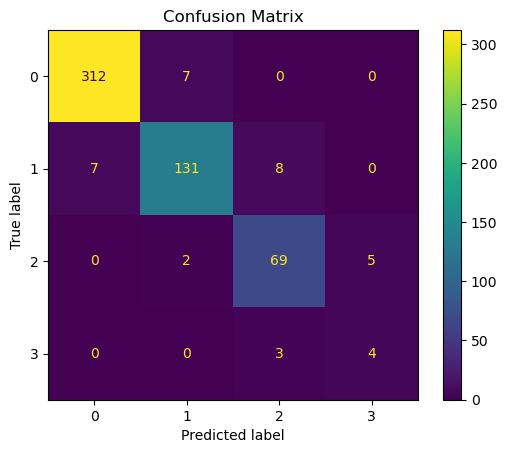

In [109]:
# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [116]:
def qwk_scorer_fi(estimator, X, y):
    """
    Custom scoring function for feature importance.
    """
    y_pred = estimator.predict(X)
    return cohen_kappa_score(y, y_pred, weights='quadratic')

X_val_processed = best_pipeline.named_steps['preprocessor'].transform(X_val)
X_val_processed = best_pipeline.named_steps['to_float32'].transform(X_val_processed)

# Compute permutation importances on the validation set
result = permutation_importance(
    best_pipeline.named_steps['nn'], X_val_processed, y_val, n_repeats=10, scoring=qwk_scorer_fi, random_state=22, 
    n_jobs=1
)

Feature names and importances are aligned.


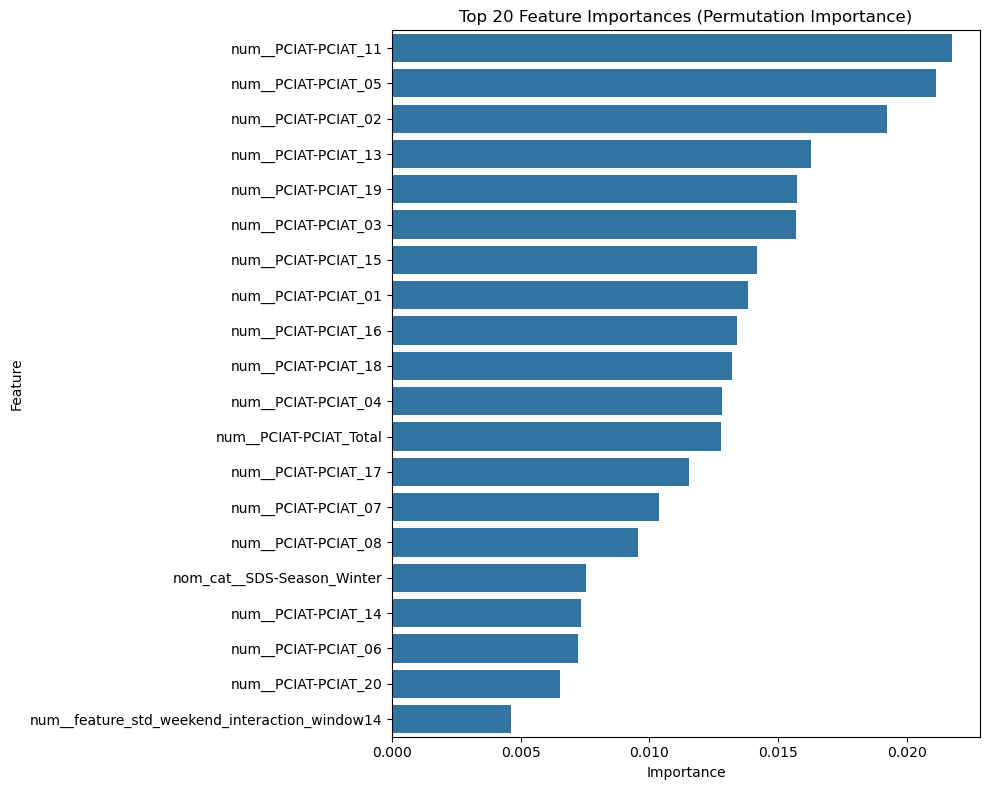

In [118]:
# Extract feature names from the preprocessor within the pipeline
feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Check for alignment
if len(feature_names) != len(result.importances_mean):
    print("Mismatch between feature names and importances.")
    # Identify missing features
    missing_importances = feature_names[len(result.importances_mean):]
    print(f"{len(missing_importances)} features are missing from permutation importances:")
    print(missing_importances)
else:
    print("Feature names and importances are aligned.")

# Create DataFrame for importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
})

# Sort the DataFrame
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Top 20 Feature Importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances (Permutation Importance)')
plt.tight_layout()
plt.show()

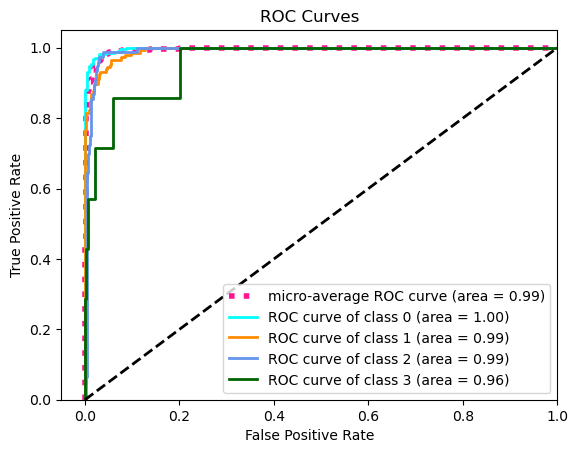

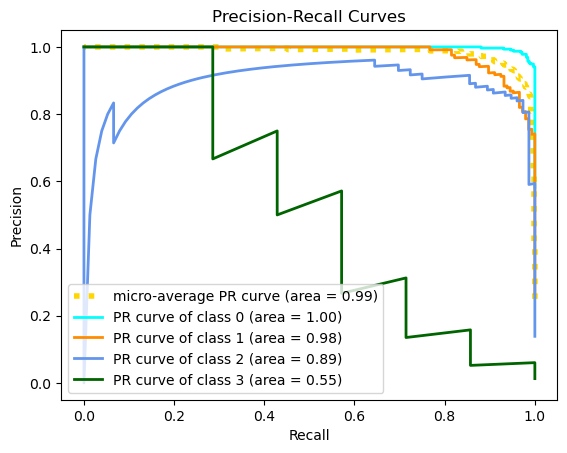

In [120]:
# Obtain the predicted probabilities for the validation set
y_val_proba = best_pipeline.predict_proba(X_val)

# Binarize the output labels
y_val_binarized = label_binarize(y_val, classes=classes)

# For each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_val_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    pr_auc[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_binarized.ravel(), y_val_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute micro-average PR curve and PR area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
pr_auc["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen']
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

# Plot all PR curves
plt.figure()
plt.plot(recall["micro"], precision["micro"],
         label='micro-average PR curve (area = {0:0.2f})'
               ''.format(pr_auc["micro"]),
         color='gold', linestyle=':', linewidth=4)

for i, color in zip(range(len(classes)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='PR curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], pr_auc[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()

# Feature Selection - Filter Method

In [138]:
def create_pipeline(input_size, study_best_params):
    # Extract parameters from study_best_params
    lr = study_best_params['lr']
    max_epochs = study_best_params['max_epochs']
    dropout = study_best_params['dropout']
    hidden_sizes = study_best_params['hidden_sizes']
    optimizer_str = study_best_params['optimizer']
    activation_str = study_best_params['activation']
    
    # Map activation functions
    activation_map = {
        'ReLU': nn.ReLU(),
        'LeakyReLU': nn.LeakyReLU(),
        'ELU': nn.ELU()
    }
    
    # Get the activation function
    nonlin = activation_map.get(activation_str, nn.ReLU())  # Default to ReLU if not found
    
    # Get the optimizer class
    optimizer_cls = torch.optim.Adam if optimizer_str == 'Adam' else torch.optim.SGD
    
    # Prepare parameters for NeuralNetClassifier
    nn_params = {
        'max_epochs': max_epochs,
        'lr': lr,
        'optimizer': optimizer_cls
    }
    
    module_params = {
        'inp_size': input_size,
        'hidden_sizes': hidden_sizes,
        'dropout': dropout,
        'nonlin': nonlin
    }
    
    # Configure neural network
    net = NeuralNetClassifier(
        module=MyModule,
        module__inp_size=module_params['inp_size'],
        module__hidden_sizes=module_params['hidden_sizes'],
        module__nonlin=module_params['nonlin'],
        module__dropout=module_params['dropout'],
        max_epochs=nn_params['max_epochs'],
        lr=nn_params['lr'],
        optimizer=optimizer_cls,
        criterion=torch.nn.CrossEntropyLoss(weight=class_weights_tensor),
        batch_size=256,
        iterator_train__shuffle=True,
        device=device,
        verbose=0,
    )
    
    # Add momentum for SGD if applicable
    if optimizer_str == 'SGD':
        momentum = study_best_params.get('momentum', 0.0)
        net.set_params(optimizer__momentum=momentum)
    
    # Create the full pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('to_float32', to_float32),
        ('nn', net)
    ])
    
    return pipeline

In [139]:
# Define 'categorical_cols' as the combination of ordinal and nominal
categorical_cols = ordinal_categorical_cols + nominal_categorical_cols

# Create a temporary preprocessor for mutual information computation
temp_mi_preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('ord_cat', ordinal_categorical_pipeline, ordinal_categorical_cols),
    ('nom_cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]), nominal_categorical_cols)
], remainder='drop', sparse_threshold=0)

# Fit and transform the training data for mutual information
X_train_mi = temp_mi_preprocessor.fit_transform(X_train[categorical_cols + numerical_cols])

# Convert to numpy array
X_train_mi = np.array(X_train_mi)

# Define which features are discrete
discrete_features = [True] * (len(ordinal_categorical_cols) + len(nominal_categorical_cols)) + [False] * len(numerical_cols)

In [140]:
# Compute mutual information scores
mi_scores = mutual_info_classif(
    X_train_mi,
    y_train,
    discrete_features=discrete_features,
    random_state=22
)

# Create a dictionary mapping feature names to MI scores
mi_scores_dict = dict(zip(categorical_cols + numerical_cols, mi_scores))

# Sort features by MI scores (ascending order)
sorted_features = sorted(mi_scores_dict.items(), key=lambda x: x[1])  # Least to most important

In [141]:
# Initialize baseline score
# Create a temporary pipeline to determine input size
temp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('to_float32', to_float32)
])
temp_pipeline.fit(X_train)
X_train_processed_temp = temp_pipeline.transform(X_train)
num_input_features = X_train_processed_temp.shape[1]

In [142]:
# Create pipeline with best_params and correct input size
pipeline_baseline = create_pipeline(num_input_features, best_params)
baseline_scores = cross_val_score(
    pipeline_baseline, 
    X_train, 
    y_train, 
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=22),
    scoring=qwk_scorer_skorch, 
    n_jobs=-1
)
baseline_score = baseline_scores.mean()
print(f"Baseline Cross-Validated QWK Score: {baseline_score:.4f}")

Baseline Cross-Validated QWK Score: 0.9549


In [144]:
# Initialize feature selection variables
features_to_remove = []
current_features = list(categorical_cols + numerical_cols)
current_score = baseline_score

for feature, score in sorted_features:
    if feature not in current_features:
        continue  # Already removed
    
    # Tentatively remove the feature
    tentative_features = current_features.copy()
    tentative_features.remove(feature)
    
    # Update numerical and categorical columns accordingly
    updated_numerical_cols = [col for col in numerical_cols if col in tentative_features]
    updated_categorical_cols = [col for col in categorical_cols if col in tentative_features]
    
    # Recreate the preprocessor with updated columns
    preprocessor_fs = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, updated_numerical_cols),
        ('ord_cat', ordinal_categorical_pipeline, [col for col in updated_categorical_cols if col in ordinal_categorical_cols]),
        ('nom_cat', nominal_categorical_pipeline, [col for col in updated_categorical_cols if col in nominal_categorical_cols])
    ], remainder='drop', sparse_threshold=0)
    
    # Create a new pipeline with the updated preprocessor
    pipeline_fs = Pipeline([
        ('preprocessor', preprocessor_fs),
        ('to_float32', to_float32),
        ('nn', NeuralNetClassifier(
            module=MyModule,
            module__inp_size=None,  # Placeholder, will set after fitting preprocessor
            module__hidden_sizes=best_params['hidden_sizes'],
            module__nonlin={
                'ReLU': nn.ReLU(),
                'LeakyReLU': nn.LeakyReLU(),
                'ELU': nn.ELU()
            }[best_params['activation']],
            module__dropout=best_params['dropout'],
            max_epochs=best_params['max_epochs'],
            lr=best_params['lr'],
            optimizer=torch.optim.Adam if best_params['optimizer'] == 'Adam' else torch.optim.SGD,
            criterion=torch.nn.CrossEntropyLoss(weight=class_weights_tensor),
            batch_size=256,
            iterator_train__shuffle=True,
            device=device,
            verbose=0,
        ))
    ])
    
    # Add momentum for SGD if applicable
    if best_params['optimizer'] == 'SGD':
        momentum = best_params.get('momentum', 0.0)
        pipeline_fs.named_steps['nn'].set_params(optimizer__momentum=momentum)
    
    # Fit the preprocessor to the tentative training data
    pipeline_fs.named_steps['preprocessor'].fit(X_train[updated_categorical_cols + updated_numerical_cols])
    
    # Transform the training data
    X_train_fs = pipeline_fs.named_steps['preprocessor'].transform(X_train[updated_categorical_cols + updated_numerical_cols])
    X_train_fs = pipeline_fs.named_steps['to_float32'].transform(X_train_fs)
    
    # Set the input size
    num_input_features_fs = X_train_fs.shape[1]
    pipeline_fs.named_steps['nn'].set_params(module__inp_size=num_input_features_fs)
    
    # Perform cross-validation
    scores = cross_val_score(
        pipeline_fs, 
        X_train[updated_categorical_cols + updated_numerical_cols], 
        y_train, 
        cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=22),
        scoring=qwk_scorer_skorch, 
        n_jobs=-1
    )
    mean_score = scores.mean()
    
    if mean_score >= current_score:
        # Keep the feature removed
        features_to_remove.append(feature)
        current_score = mean_score
        current_features = tentative_features
        #print(f"Removed feature: {feature}, New QWK Score: {mean_score:.4f}")
    else:
        # Do not remove the feature
        pass
        #print(f"Re-added feature: {feature}, QWK Score: {mean_score:.4f}")
        
print(f"\nFeatures to remove: {features_to_remove}")


Features to remove: ['feature_std_weekend_interaction_window16', 'Muscle_to_Fat', 'interaction_z_score_weekend_interaction_window14', 'feature_std_weekday_interaction_window19', 'feature_std_weekend_interaction_window11', 'FGC-FGC_PU']


In [145]:
# Define final selected features
final_numerical_cols = [col for col in numerical_cols if col not in features_to_remove]
final_categorical_cols = [col for col in categorical_cols if col not in features_to_remove]

# Recreate the preprocessor with final selected features
preprocessor_final = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, final_numerical_cols),
    ('ord_cat', ordinal_categorical_pipeline, [col for col in final_categorical_cols if col in ordinal_categorical_cols]),
    ('nom_cat', nominal_categorical_pipeline, [col for col in final_categorical_cols if col in nominal_categorical_cols])
], remainder='drop', sparse_threshold=0)

# Create the final pipeline
pipeline_final = Pipeline([
    ('preprocessor', preprocessor_final),
    ('to_float32', to_float32),
    ('nn', NeuralNetClassifier(
        module=MyModule,
        module__inp_size=None,  # Placeholder, will set after fitting preprocessor
        module__hidden_sizes=best_params['hidden_sizes'],
        module__nonlin={
            'ReLU': nn.ReLU(),
            'LeakyReLU': nn.LeakyReLU(),
            'ELU': nn.ELU()
        }[best_params['activation']],
        module__dropout=best_params['dropout'],
        max_epochs=best_params['max_epochs'],
        lr=best_params['lr'],
        optimizer=torch.optim.Adam if best_params['optimizer'] == 'Adam' else torch.optim.SGD,
        criterion=torch.nn.CrossEntropyLoss(weight=class_weights_tensor),
        batch_size=256,
        iterator_train__shuffle=True,
        device=device,
        verbose=0,
    ))
])

# Add momentum for SGD if applicable
if best_params['optimizer'] == 'SGD':
    momentum = best_params.get('momentum', 0.0)
    pipeline_final.named_steps['nn'].set_params(optimizer__momentum=momentum)

# Fit the preprocessor on the entire training data
pipeline_final.named_steps['preprocessor'].fit(X_train[final_categorical_cols + final_numerical_cols])

# Transform training and validation data
X_train_final = pipeline_final.named_steps['preprocessor'].transform(X_train[final_categorical_cols + final_numerical_cols])
X_train_final = pipeline_final.named_steps['to_float32'].transform(X_train_final)

X_val_final = pipeline_final.named_steps['preprocessor'].transform(X_val[final_categorical_cols + final_numerical_cols])
X_val_final = pipeline_final.named_steps['to_float32'].transform(X_val_final)

# Set the input size for the neural network
num_input_features_final = X_train_final.shape[1]
pipeline_final.named_steps['nn'].set_params(module__inp_size=num_input_features_final)

# Fit the final pipeline on the training data
pipeline_final.fit(X_train[final_categorical_cols + final_numerical_cols], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=7)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Basic_Demos-Age',
                                                   'CGAS-CGAS_Score',
                                                   'Physical-BMI',
                                                   'Physical-Height',
                                                   'Physical-Weight',
                                                   'Physical-Waist_Circumference',
                                                   'Physical-Diastolic_BP',
                                                   'Physical-HeartRate',
                                                   'Physical-Sy...
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (net): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.44594184927390784, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.44594184927390784, inplace=False)
      (6): Linear(in_features=64, out_features=4, bias=True)
    )
  ),
))])

In [146]:
# Predict on the validation set
y_val_pred = pipeline_final.predict(X_val[final_categorical_cols + final_numerical_cols])
val_qwk = cohen_kappa_score(y_val, y_val_pred, weights='quadratic')
print(f"\nValidation QWK Score after Feature Selection: {val_qwk:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Validation QWK Score after Feature Selection: 0.9555

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       319
           1       0.92      0.91      0.92       146
           2       0.91      0.92      0.92        76
           3       0.67      0.57      0.62         7

    accuracy                           0.95       548
   macro avg       0.87      0.85      0.86       548
weighted avg       0.95      0.95      0.95       548



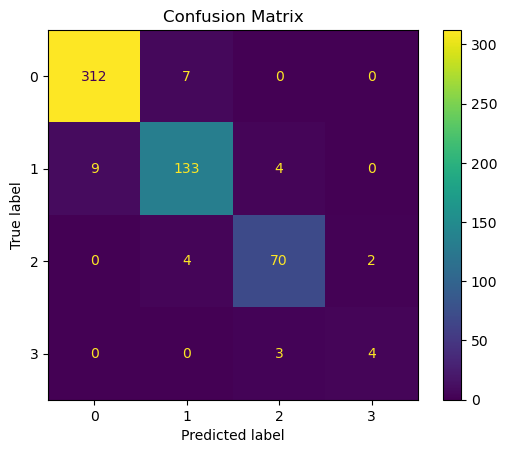

In [147]:
# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

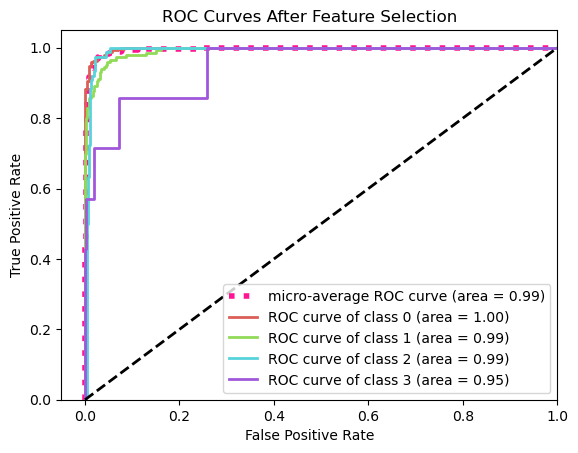

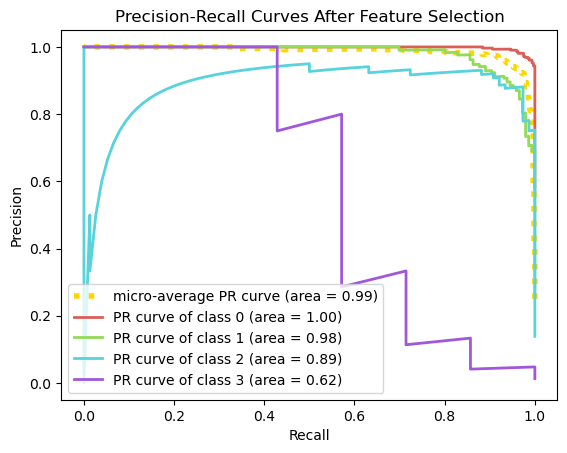

In [148]:
# Binarize the output for multi-class ROC and PR curves
y_val_binarized = label_binarize(y_val, classes=classes)

# Obtain the predicted probabilities for the validation set after feature selection
y_val_proba_fs = pipeline_final.predict_proba(X_val[final_categorical_cols + final_numerical_cols])

# Initialize dictionaries for metrics
fpr_fs = dict()
tpr_fs = dict()
roc_auc_fs = dict()
precision_fs = dict()
recall_fs = dict()
pr_auc_fs = dict()

# Define colors for plotting
colors = sns.color_palette("hls", len(classes))

for i in range(len(classes)):
    fpr_fs[i], tpr_fs[i], _ = roc_curve(y_val_binarized[:, i], y_val_proba_fs[:, i])
    roc_auc_fs[i] = auc(fpr_fs[i], tpr_fs[i])

    precision_fs[i], recall_fs[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba_fs[:, i])
    pr_auc_fs[i] = average_precision_score(y_val_binarized[:, i], y_val_proba_fs[:, i])

# Micro-average ROC curve and ROC area
fpr_fs["micro"], tpr_fs["micro"], _ = roc_curve(y_val_binarized.ravel(), y_val_proba_fs.ravel())
roc_auc_fs["micro"] = auc(fpr_fs["micro"], tpr_fs["micro"])

# Micro-average Precision-Recall curve and PR area
precision_fs["micro"], recall_fs["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba_fs.ravel())
pr_auc_fs["micro"] = average_precision_score(y_val_binarized, y_val_proba_fs, average="micro")

# Plot ROC Curves
plt.figure()
plt.plot(fpr_fs["micro"], tpr_fs["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_fs["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr_fs[i], tpr_fs[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc_fs[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves After Feature Selection')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curves
plt.figure()
plt.plot(recall_fs["micro"], precision_fs["micro"],
         label='micro-average PR curve (area = {0:0.2f})'
               ''.format(pr_auc_fs["micro"]),
         color='gold', linestyle=':', linewidth=4)

for i, color in zip(range(len(classes)), colors):
    plt.plot(recall_fs[i], precision_fs[i], color=color, lw=2,
             label='PR curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], pr_auc_fs[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves After Feature Selection')
plt.legend(loc="lower left")
plt.show()

# Predict on Test Data

In [149]:
X_test_final = pipeline_final.named_steps['preprocessor'].transform(X_test[final_categorical_cols + final_numerical_cols])
X_test_final = pipeline_final.named_steps['to_float32'].transform(X_test_final)
y_test_pred = pipeline_final.predict(X_test[final_categorical_cols + final_numerical_cols])
output_df = pd.DataFrame({'id': test_df['id'], 'sii': y_test_pred})

output_df

# Use best_pipeline instead of pipeline_final to use the neural network before FS

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,1
4,0016bb22,1
5,001f3379,0
6,0038ba98,1
7,0068a485,1
8,0069fbed,1
9,0083e397,2
